# Demonstration on 6x6 images

In [34]:
import numpy as np

print(np.random.choice(2, size=(4,)))

[1 0 0 0]


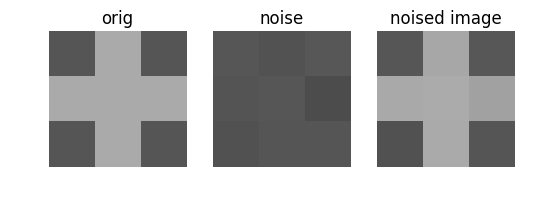

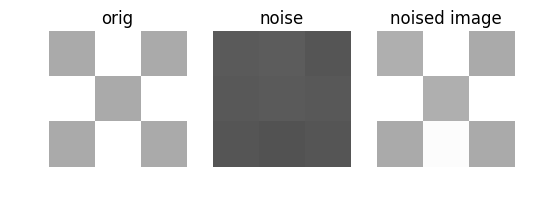

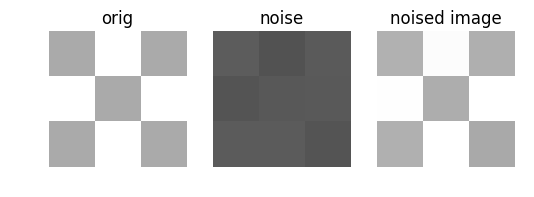

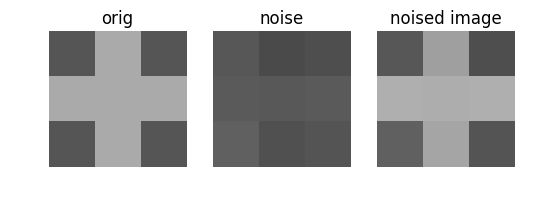

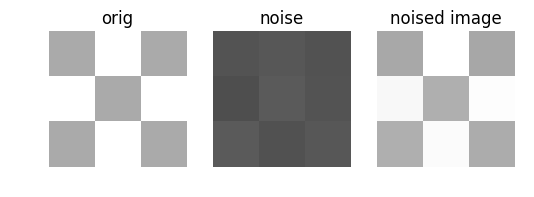

In [112]:
### import numpy as np
import matplotlib.pyplot as plt
import math


num_classes = 2
image_size = 3
N = 10
num_samples_to_print = 5
sigma_X = 0.05

class_descriptions = [
    {
        'sprite': [
            [0,1,0],
            [1,1,1],
            [0,1,0]
        ],
        'sprite_x': 0,
        'sprite_y': 0
    },
    {
        'sprite': [
            [1,1,1],
            [1,0,1],
            [1,1,1]
        ],
        'sprite_x': 0,
        'sprite_y': 0
    },
    {
        'sprite': [
            [1,0,0],
            [1,1,0],
            [1,1,1]
        ],
        'sprite_x': 0,
        'sprite_y': 3
    },
    {
        'sprite': [
            [1,1,1],
            [0,1,0],
            [0,1,0]
        ],
        'sprite_x': 3,
        'sprite_y': 3
    }
]

def class_descriptions_to_class_pics():
    class_pics = []
    for i, desc in enumerate(class_descriptions):
        if i >= num_classes:
            break
        pic = np.zeros((image_size, image_size), dtype=np.float32)
        for dx in range(3):
            for dy in range(3):
                if desc['sprite'][dy][dx] == 1:
                    pic[desc['sprite_y'] + dy, desc['sprite_x'] + dx] = 1.0
        class_pics.append(pic)
    return class_pics

class_pics = class_descriptions_to_class_pics()
# print(class_pics)

def print_images(titles, images):
    plt.figure(1)
    num_figures = len(images)
    for i, image in enumerate(images):
        image_size = image.shape[0]
        image_min = np.min(image)
        image_max = np.max(image)
        image_min = -1
        image_max = 2
        image_range = image_max - image_min
        image = np.maximum(image_min, image)
        image = np.minimum(image_max, image)
        image = (image - image_min) / image_range
        image_rgb = np.zeros((image_size, image_size, 3), dtype=np.float32)
        image_rgb[:,:,0] = image
        image_rgb[:,:,1] = image
        image_rgb[:,:,2] = image
        plt.subplot(1, num_figures, i + 1)
        plt.imshow(image_rgb, interpolation='nearest')
        plt.axis('off')
        plt.title(titles[i])
    plt.show()

def draw_samples(N, class_pics):
    samples = []
    samples_to_print = set(np.random.choice(N, (num_samples_to_print,), replace=False))
    for n in range(N):
        image = np.zeros((image_size, image_size), dtype=np.float32)
        features = np.random.choice(2, size=(num_classes,))
#         print(features)
        for k, v in enumerate(features):
            if v == 1:
                image += class_pics[k]
        image_orig = np.copy(image)
#         print_image(image)

        noise = np.random.randn(image_size, image_size).astype(np.float32) * sigma_X
#         print_image(noise)

        image += noise
        if n in samples_to_print:
#             print(n)
            print_images(['orig', 'noise', 'noised image'], [image_orig, noise, image])

        samples.append(image)
    return samples

samples = draw_samples(N, class_pics)


In [121]:
Z_columns = []
column = np.random.choice(2, (N,))
Z_columns.append(column)
K_plus = len(Z_columns)
# print(Z_columns)
M = []
M.append(np.sum(Z_columns[0]))
# print('M', M)

sigma_A = 0.5
sigma_X = 1.7
alpha = 1.0

for it in range(10):
    for n in range(N):
        k = 0
        while k < len(Z_columns):
            column = Z_columns[k]
            m = M[k]
            if m == 1 and column[n] == 1:
                # means that m_{-i} is zero
                # so, delete the column
                del Z_columns[k]
                del M[k]
                k -= 1
            else:
                # M_{-i} > 0
                # what do we do now???
            k += 1

[array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0])]
M [3]


At this point, I looked at the tutorial's equation 22.  But there's a proportional-to sign, $\propto$.  How to handle this?  Since I'm not trying to do this research from scratch, just reproduce/understand the existing research, I reached out to Mr Google, to look for more explanations.  I found the following video, from Finale Doshi-Velez, which I'm going to interlude out to now

## Interlude: presentation "Accelerated Gibbs Sampling for the Indian Buffet Process", Doshi-Velez, Ghahramani

It's here: http://videolectures.net/icml09_doshi_velez_ags/

Corresponding slides: http://videolectures.net/site/normal_dl/tag=47975/icml09_doshi_velez_ags_01.pdf

It's still advised by Ghahramani, but the student is now Doshi-Velez.  Going through the lecture:

Finale notes that, for model:

$$\mathbf{X} = \mathbf{Z}\mathbf{A} + \mathbf{E}$$

- can compute $P(\mathbf{Z} \mid \mathbf{Z})$, but expensive
- can compute $P(\mathbf{A} \mid \mathbf{X}, \mathbf{Z})$ (just a linear expression (?))
- cannot compute $P(\mathbf{Z)}, \mathbf{A} \mid \mathbf{Z})$

For this lecture, Doshi-Velez is going to target putting a window over the data, $\mathbf{X}$, and $\mathbf{Z}$, so they will only consider a window of $W$ points at a time, splitting each matrix into:

$$\mathbf{X} =
\begin{bmatrix}
\mathbf{X}_{-W} \\
\mathbf{X}_{W} \\
\end{bmatrix}$$

and:

$$\mathbf{Z} =
\begin{bmatrix}
\mathbf{Z}_{-W} \\
\mathbf{Z}_{W} \\
\end{bmatrix}$$

(where here the data points are arranged as one row per data point, and the features are the columns).

They do this, because they want to target large datasets.

Then, Doshi-Velez goes over the following two principle sampling schemes:

### Uncollapsed sampling

![](img/basicsampling_1.png)

![](img/basicsampling_2.png)

![](img/basicsampling_A.png)

Uncollapsed sampling:

- each iteration is quick (or should be, otherwise we have other issues to deal with)
- but mixing very slow

### Collapsed sampling

![](img/collapsed_gibbs.png)

- mixing fast
- but each iteration can be slow/challenging, and
- we lose the independences between the samples and latent features within the window, and outside of the window

### Their idea: Keep a posterior on A

![](img/acceleratedsampling.png)

- data samples and latent variables within the window remain independent of those outside of it
- (conditional on the posterior of A)


Then, Doshi-Velez goes over the maths of the accelerated sampling:

Consider one element, and here the notation has changed from $w$/$-w$ to $n$/$-n$:

$$P(Z_{nk} = 1 \mid Z_{-nk}, \mathbf{X})$$

$$\propto P(Z_{nk} \mid \mathbf{Z}_{-nk})\,P(\mathbf{X} \mid \mathbf{Z})$$

So, it took me a while to figure out why this statement is proportionality, not equality.  Finally I realized we can do, following the hint about 'bayes rule' in the slides:

$$P(Z_{nk} = 1 \mid \mathbf{Z}_{-nk}, \mathbf{X})
= 
\frac{
   P(\mathbf{X} \mid Z_{nk} = 1, \mathbf{Z}_{-nk})\, P(Z_{nk} = 1 \mid \mathbf{Z}_{-nk})
}
{
   P(\mathbf{X} \mid \mathbf{Z}_{-nk})
}$$

$$\propto P(Z_{nk} \mid \mathbf{Z}_{-nk})\,P(\mathbf{X} \mid \mathbf{Z})$$

as stated.

Continuing, by writing $P(\mathbf{X} \mid \mathbf{Z})$ as a marginalization over $\mathbf{A}$:

$$=
P(Z_{nk} \mid \mathbf{Z}_{-nk})
\int_A P(\mathbf{X} \mid \mathbf{Z}, \mathbf{A})\, P(\mathbf{A})\,d\mathbf{A}
$$

Factorizing over $\mathbf{X}_n$ and $\mathbf{X}_{-n}$:

$$
=
P(Z_{nk} \mid \mathbf{Z}_{-nk})
\int_A P(\mathbf{X}_n \mid \mathbf{Z}_n, \mathbf{A})\, P(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n}, \mathbf{A})\, P(\mathbf{A})\,d\mathbf{A}
$$
